In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ganette import Ganette
from imagine.color import conversion
from imagine.functional import functional as f
import itertools
from sklearn.model_selection import cross_val_score

### Loading data

In [2]:
df = pd.read_csv("preprocessed/colors.csv", na_values=-1).dropna().convert_dtypes()
df

,id,skin_r,skin_g,skin_b,hair_r,hair_g,hair_b,lips_r,lips_g,lips_b,...,lipstick_b,eyeshadow0_r,eyeshadow0_g,eyeshadow0_b,eyeshadow1_r,eyeshadow1_g,eyeshadow1_b,eyeshadow2_r,eyeshadow2_g,eyeshadow2_b
0,tKGcZvehYuM,177,133,128,21,21,21,166,99,100,...,101,84,70,70,122,98,94,155,123,115
1,10pn1m9I-Ng,77,46,37,0,0,0,102,48,42,...,39,40,24,18,73,56,51,102,74,65
2,EPwG8SijLnY,194,144,115,53,42,36,176,110,106,...,34,61,41,45,123,89,86,198,161,144
3,GpQhFtH4lFM,176,121,109,27,8,14,175,107,121,...,46,113,66,59,139,87,73,174,130,150
4,es2nGInaFYE,166,136,132,116,98,78,148,84,101,...,58,70,46,45,114,79,74,145,112,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,B8h-giS3ArE,179,133,116,52,37,31,167,81,91,...,51,105,46,44,145,90,87,197,151,130
956,eATX104iwFc,218,168,133,19,3,2,211,111,118,...,66,56,20,19,111,64,54,155,103,86
957,llbdfAwpHvw,189,153,146,91,76,68,167,88,103,...,96,80,46,41,112,69,65,134,88,81
958,JMgGXBSybXE,197,139,122,33,27,25,183,100,107,...,113,114,74,59,142,97,82,180,131,119


### Preprocessing

In [3]:
def make_lab_columns(df, part):
    rgb_columns = ["{}_{}".format(part, c) for c in ["r", "g", "b"]]
    rgb_values = df[rgb_columns].values.astype(np.uint8)
    lab_values = f.Join([
        f.Rearrange("n c -> 1 n c"),
        conversion.RgbToLab,
        f.Rearrange("1 n c -> n c")
    ])(rgb_values)
    return pd.DataFrame(lab_values, index=df.index, columns=["{}_{}".format(part, c) for c in ["l", "a", "b"]])

In [4]:
parts = ["skin", "hair", "lips", "eyes", "lipstick", "eyeshadow0", "eyeshadow1", "eyeshadow2"]
lab_df = pd.concat([make_lab_columns(df, p) for p in parts], axis=1)
lab_df

,skin_l,skin_a,skin_b,hair_l,hair_a,hair_b,lips_l,lips_a,lips_b,eyes_l,...,lipstick_b,eyeshadow0_l,eyeshadow0_a,eyeshadow0_b,eyeshadow1_l,eyeshadow1_a,eyeshadow1_b,eyeshadow2_l,eyeshadow2_a,eyeshadow2_b
0,152,144,137,17,128,128,126,155,139,65,...,140,80,134,130,112,137,134,139,139,137
1,58,141,140,0,128,128,69,152,143,1,...,144,27,134,136,65,134,134,87,138,138
2,163,143,151,46,132,134,136,154,141,115,...,129,48,138,129,105,141,135,176,139,142
3,143,148,143,10,136,128,135,157,132,106,...,128,85,148,141,108,148,145,151,148,124
4,151,139,134,109,132,142,111,157,130,85,...,146,56,139,133,95,142,137,128,140,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,152,143,144,42,134,135,116,164,139,96,...,146,69,154,142,113,150,139,169,142,146
956,185,142,153,5,134,130,149,168,142,107,...,142,30,146,138,83,147,143,124,147,146
957,169,140,137,86,133,135,120,162,134,72,...,131,59,143,138,87,146,138,108,146,140
958,161,148,146,27,131,131,133,162,139,83,...,137,91,143,144,116,144,144,151,145,142


In [5]:
y_df = lab_df.iloc[:, :12]
x_df = lab_df.iloc[:, 12:]

In [6]:
from sklearn.preprocessing import StandardScaler
X_scaler, Y_scaler = StandardScaler(), StandardScaler()

In [7]:
X = X_scaler.fit_transform(x_df)
Y = Y_scaler.fit_transform(y_df)

### Model

In [8]:
g = Ganette(batch_size=64, epochs=500, generator_lr=0.0001, discriminator_lr=0.0004, gp_lambda=1)

### Cross validation score

In [9]:
cross_val_score(g, X, Y).mean()

-3.439452600479126

### Refitted

In [10]:
g = g.fit(X, Y)

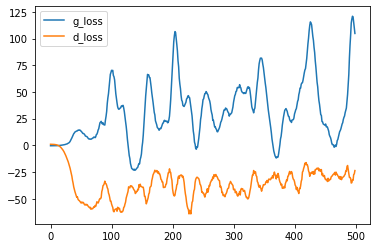

In [11]:
plt.plot(g.logger_.history["g_loss"], label="g_loss")
plt.plot(g.logger_.history["d_loss"], label="d_loss")
plt.legend()

### Sample results

In [12]:
def show_colors(colors, scale=2, labels=[]):
    def show_color(color_array, axis, label=None):
        axis.imshow([[color_array]])
        axis.set_axis_off()
        if label:
            axis.set_title(label)
        
    n = len(colors) // 3
    
    fig, axs = plt.subplots(1, n, figsize=(n*scale, scale))
    for i, label in itertools.zip_longest(range(n), labels):
        color = colors[3*i : 3*i + 3]
        show_color(color, axs[i], label)
        
    plt.tight_layout()
    plt.show()

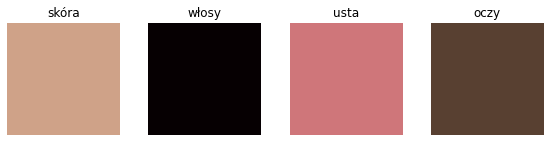

In [13]:
y = Y[np.random.choice(len(Y))][None, ...]
y_show = Y_scaler.inverse_transform(y).astype(np.uint8)
y_show = f.Rearrange("n (f fs) -> n f fs", fs=3)(y_show)
y_show = conversion.LabToRgb(y_show)
y_show = f.Rearrange("n f fs -> n (f fs)", fs=3)(y_show)
show_colors(y_show[0], labels=["skóra", "włosy", "usta", "oczy"])

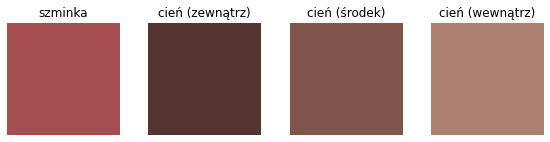

In [14]:
x_fake = g.sample(y)
x_fake = X_scaler.inverse_transform(x_fake).astype(np.uint8)
x_fake = f.Rearrange("n (f fs) -> n f fs", fs=3)(x_fake)
x_fake = conversion.LabToRgb(x_fake)
x_fake = f.Rearrange("n f fs -> n (f fs)", fs=3)(x_fake)
show_colors(x_fake[0], labels=["szminka", "cień (zewnątrz)", "cień (środek)", "cień (wewnątrz)"])

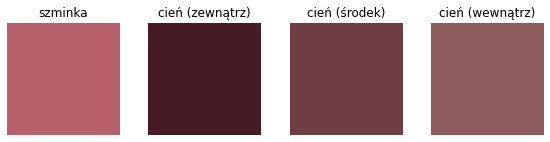

In [15]:
x_real = df.iloc[np.where((Y == y).all(axis=1))[0], 13:].values.astype(np.uint8)[0]
show_colors(x_real, labels=["szminka", "cień (zewnątrz)", "cień (środek)", "cień (wewnątrz)"])